# Perder hasta la camisa
Anton Hurtado - Problema Individual Lista 3

## Cargamos librerías necesarias

In [ ]:
# Uncomment to upgrade packages
# !pip3 install pandas --user --upgrade --quiet
# !pip3 install numpy --user --upgrade --quiet
# !pip3 install scipy --user --upgrade --quiet
# !pip3 install statsmodels --user --upgrade --quiet
# !pip3 install seaborn --user --upgrade --quiet
# !pip3 install matplotlib --user --upgrade --quiet
# !pip3 install scikit-learn --user --upgrade
!pip install scikit-optimize --user --quiet
!pip install apafib --upgrade --user --quiet

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from yellowbrick.classifier.rocauc import roc_auc
from sklearn.neural_network import MLPClassifier

import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import numpy as np
import apafib

warnings.filterwarnings('ignore')

## Apartado A

Cargamos los datos y procedemos a hacer su visualización

In [ ]:
data = apafib.load_NASDAQ()
data.head()

,GOOGLE-P,GOOGLE-V,GOOGLE-GAP,MSFT-P,MSFT-V,MSFT-GAP,AAPL-P,AAPL-V,AAPL-GAP,INTEL-P,INTEL-V,INTEL-GAP,AMD-P,AMD-V,AMD-GAP
0,45.3330,18846560,0.4800,72.15,17698800,0.78,39.3025,105320280,0.6950,34.92,26479700,0.58,12.05,58786300,0.560
1,46.2345,23326400,0.7192,73.16,14333220,0.89,39.9450,86259560,0.4950,34.65,26093400,0.57,12.17,38946780,0.230
2,46.3500,21771500,0.5285,72.72,13758650,0.62,39.9950,77507760,0.3975,34.66,19775620,0.43,12.48,44193270,0.585
3,46.0640,25323820,0.7670,72.69,17097240,0.79,39.8175,79128680,0.5475,34.71,14283180,0.34,12.50,37161680,0.320
4,45.7945,21055280,0.5027,72.82,12790300,0.87,39.9650,100738400,0.3225,34.67,14714810,0.35,12.43,29650370,0.320


In [ ]:
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
GOOGLE-P,1259.0,8.235332e+01,3.232053e+01,4.533300e+01,5.610350e+01,6.736500e+01,1.129415e+02,1.507090e+02
GOOGLE-V,1259.0,3.091715e+07,1.347789e+07,6.935060e+06,2.256946e+07,2.773012e+07,3.531136e+07,1.238938e+08
GOOGLE-GAP,1259.0,1.740178e+00,1.209965e+00,2.380000e-01,8.713000e-01,1.371000e+00,2.218750e+00,9.215500e+00
MSFT-P,1259.0,1.818206e+02,7.862105e+01,7.215000e+01,1.081500e+02,1.634900e+02,2.524850e+02,3.431100e+02
MSFT-V,1259.0,2.953929e+07,1.299424e+07,7.425603e+06,2.125149e+07,2.629290e+07,3.374066e+07,1.109450e+08
MSFT-GAP,1259.0,3.812815e+00,2.912805e+00,3.400000e-01,1.660000e+00,3.060000e+00,5.141250e+00,2.364000e+01
AAPL-P,1259.0,9.035068e+01,4.626909e+01,3.554750e+01,4.748250e+01,7.193250e+01,1.336400e+02,1.820100e+02
AAPL-V,1259.0,1.184749e+08,5.504025e+07,4.099995e+07,8.193916e+07,1.042700e+08,1.382814e+08,4.268848e+08
AAPL-GAP,1259.0,2.068242e+00,1.694044e+00,2.135000e-01,7.762500e-01,1.502500e+00,2.925000e+00,1.281000e+01
INTEL-P,1259.0,5.089460e+01,6.684044e+00,3.452000e+01,4.672000e+01,5.059000e+01,5.538000e+01,6.847000e+01


El conjunto de datos contiene información sobre la cotización de cinco empresas: Google, Microsoft, Apple, Intel y AMD; abarcando un período de cinco años. Incluye el precio final de la acción (P), el volumen de acciones negociadas (V) y la diferencia de precio (GAP) para cada empresa durante este tiempo.

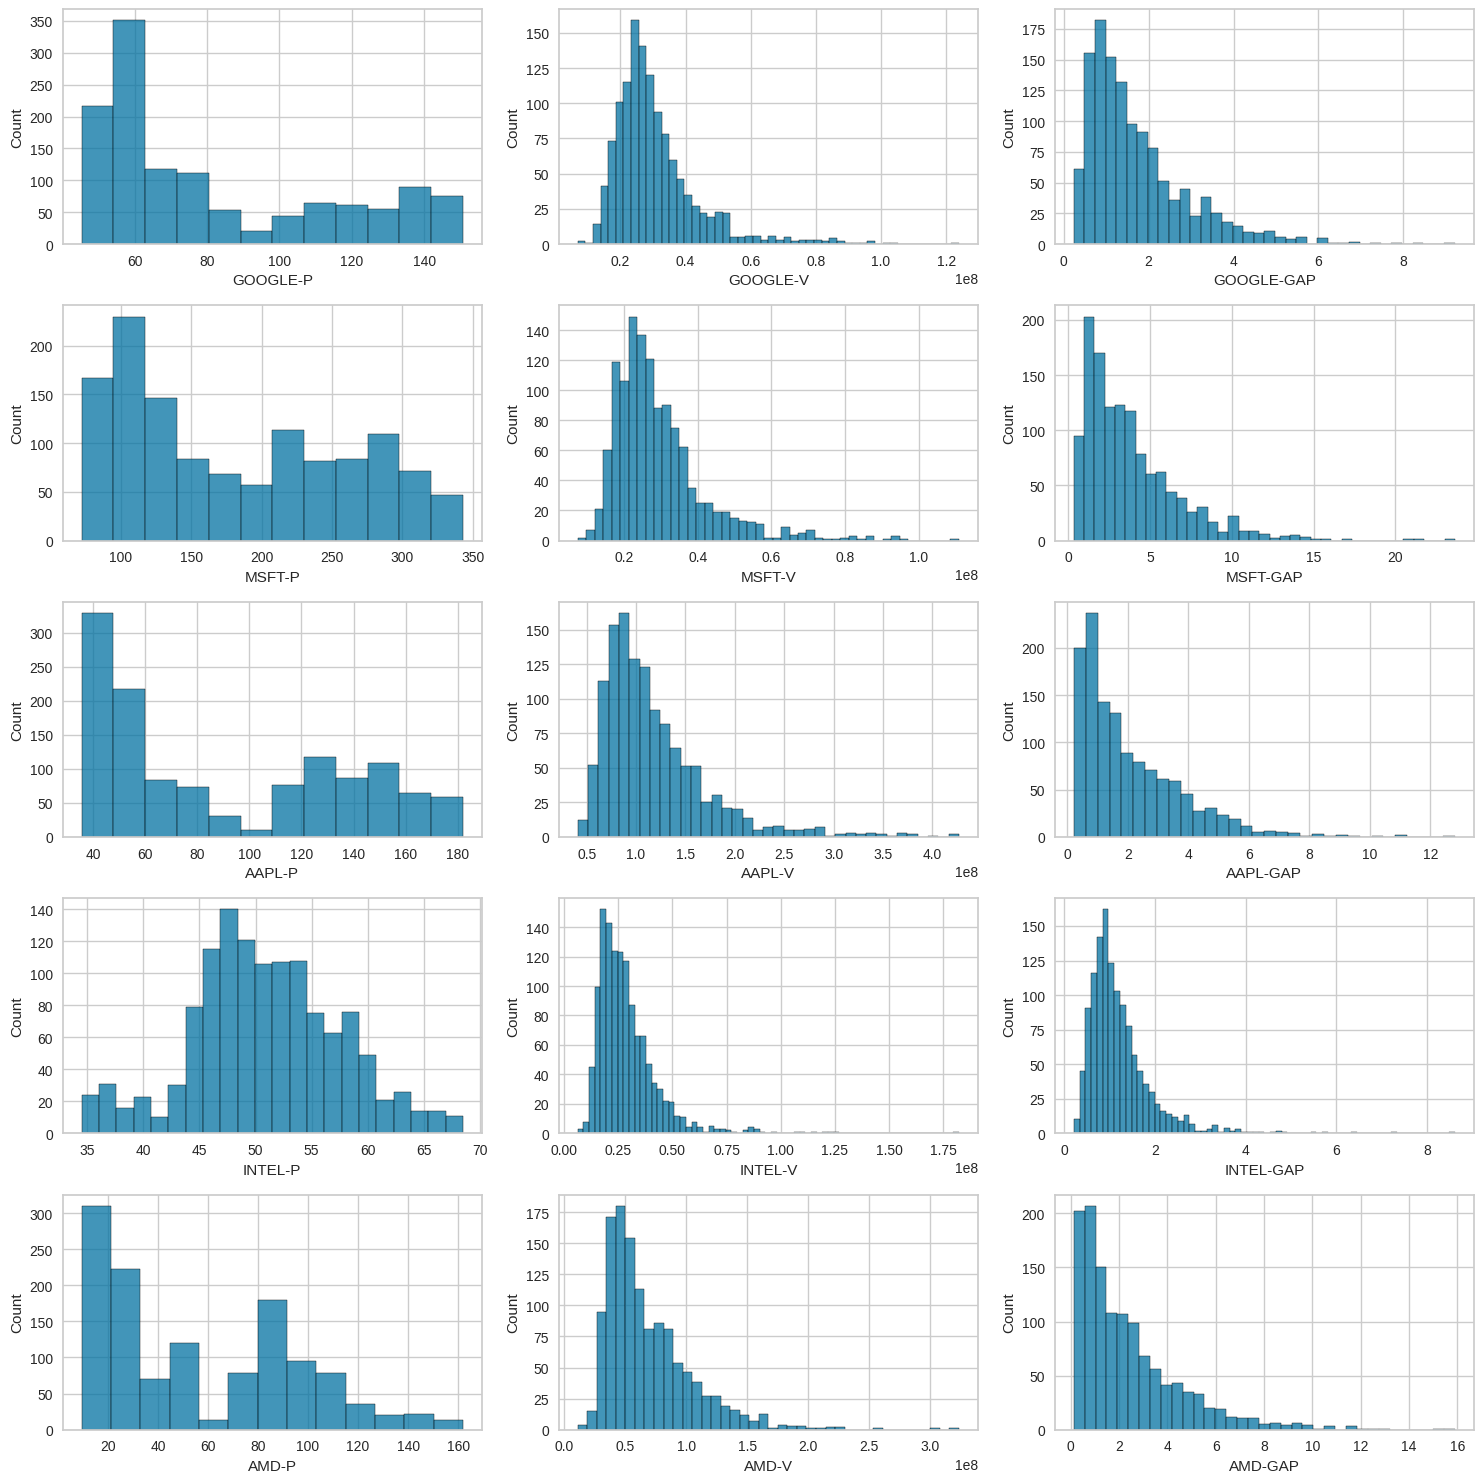

In [ ]:
fig, axes = plt.subplots(5,3,figsize=(15,15))
data_frame = pd.DataFrame(data)
data_frame.columns=data.columns
for i, c in enumerate(data.columns):
    ax = axes.reshape(-1)[i]
    if data_frame[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=data_frame,ax=ax)
    else:
        b = sns.histplot(x=c,data=data_frame,ax=ax)
plt.tight_layout()

De las anteriores gráficas podemos observar que para cada tipo de variable (P, V o GAP) siguen un comportamiento similar para las 5 empresas, exceptuando el precio por acción de Intel que sigue una distribución más gaussiana que el resto.

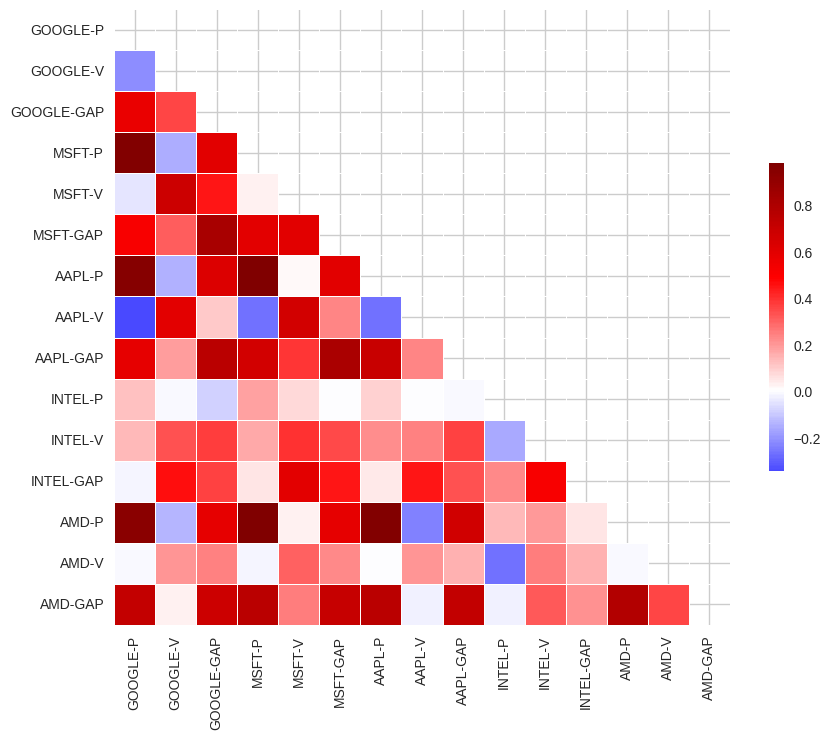

In [ ]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Del heatmap anterior podemos observar que hay una mayor correlación con las variables del mismo tipo (P, V y GAP) entre las diferentes empresas. A priori parecer ser posible predecir unas variables a partir del resto.

Ahora procedemos a dividir el datasaet en el conjunto de entrenamiento y test, normalizándolos y dividiendo los datos en ventanas.

In [ ]:
size_train = 1000
data_train = data.iloc[:size_train]
data_test = data.iloc[size_train:]

scaler = MinMaxScaler()
data_train_normalized = scaler.fit_transform(data_train.to_numpy())
data_test_normalized = scaler.transform(data_test.to_numpy())

window_length = 3
windows_train = sliding_window_view(data_train_normalized, window_length + 1, axis=0).copy()
windows_test = sliding_window_view(data_test_normalized, window_length + 1, axis=0).copy()

X_train_w = windows_train.squeeze()[:,:, :-1].reshape(window_length-size_train, window_length*data.columns.size)
X_test_w = windows_test.squeeze()[:,:,:-1].reshape(len(data)-window_length-size_train, window_length*data.columns.size)

Generamos las dos variables objetivo: si el precio de las acciones de Google subió o bajó respecto al día anterior, y si el volumen de negociación de las acciones de Google sube o no respecto al día anterior.

In [ ]:
y_train_w_price_increased = np.array(data_train.iloc[window_length:]['GOOGLE-P'].values > data_train.iloc[window_length - 1:-1]['GOOGLE-P'].values)
y_test_w_price_increased = np.array(data_test.iloc[window_length:]['GOOGLE-P'].values > data_test.iloc[window_length - 1:-1]['GOOGLE-P'].values)

y_train_w_volume_increased = np.array(data_train.iloc[window_length:]['GOOGLE-V'].values > data_train.iloc[window_length - 1:-1]['GOOGLE-V'].values)
y_test_w_volume_increased = np.array(data_test.iloc[window_length:]['GOOGLE-V'].values > data_test.iloc[window_length - 1:-1]['GOOGLE-V'].values)

## Apartado B y C
Intentamos predecir si el valor de las acciones de Google subieron o bajaron respecto al día anterior ajustando un modelo de regresión logística y un modelo de MLP explorando sus hiperparámetros utilizando la exploración bayesiana. Obtenemos:
 * acierto de validación cruzada
 * acierto en el test
 * matriz de confusión
 * curva ROC
 * informe de clasificación

### Regresión logística
*Voy a comentar los resultados en el apartado de Comparación*

In [ ]:
cls = ['Increased','Decreased']
niter = 15
ncv = 10

lr = LogisticRegression(max_iter=10000)
print("validación cruzada:", np.mean(cross_val_score(lr, X_train_w, y_train_w_price_increased, cv=ncv)))

validación cruzada: 0.5176161616161615


In [ ]:
param = {'penalty':['l2'], 'C':10**np.linspace(-3,3,51, endpoint=True)}
lr_bs =  BayesSearchCV(lr,param,n_iter=niter,cv=ncv, n_jobs=-1, refit=True,random_state=0)
lr_bs.fit(X_train_w, y_train_w_price_increased);
print("acierto de test:", accuracy_score(y_test_w_price_increased, lr_bs.predict(X_test_w)))

acierto de test: 0.515625


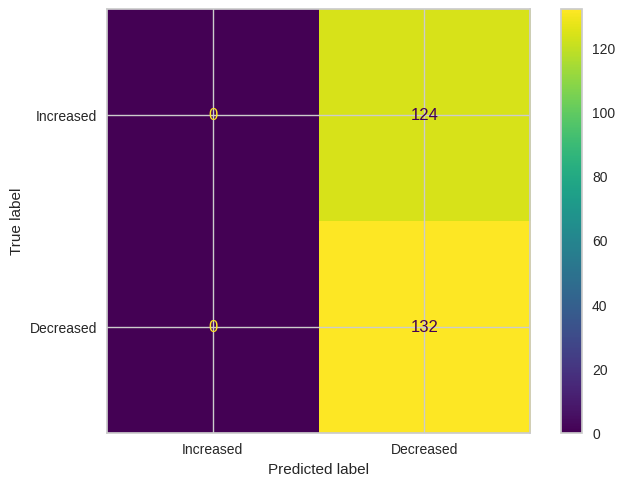

In [ ]:
ConfusionMatrixDisplay.from_estimator(lr_bs, X_test_w,y_test_w_price_increased, display_labels=cls, ax=plt.subplot());

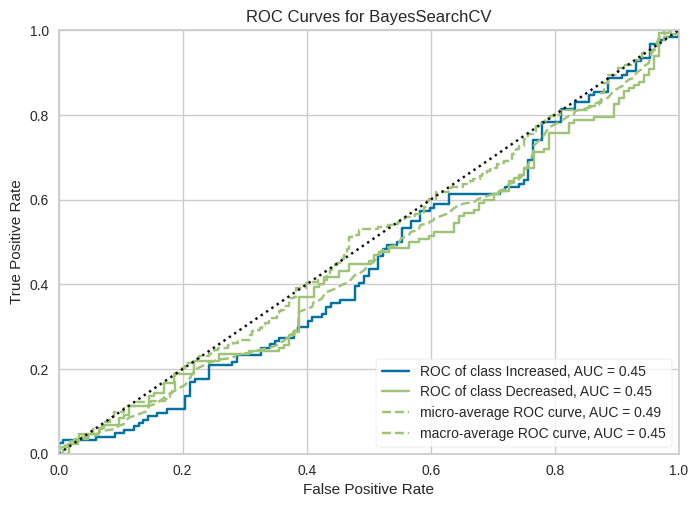

In [ ]:
roc_auc(lr_bs, X_train_w, y_train_w_price_increased, X_test_w, y_test_w_price_increased, classes=cls);

In [ ]:
print(classification_report(lr_bs.predict(X_test_w), y_test_w_price_increased,target_names=cls))

              precision    recall  f1-score   support

   Increased       0.00      0.00      0.00         0
   Decreased       1.00      0.52      0.68       256

    accuracy                           0.52       256
   macro avg       0.50      0.26      0.34       256
weighted avg       1.00      0.52      0.68       256



### MLP
*Voy a comentar los resultados en el apartado de Comparación*

In [ ]:
mlp =  MLPClassifier(max_iter=10000,early_stopping=True,random_state=0)
print("validación cruzada:", np.mean(cross_val_score(mlp, X_train_w, y_train_w_price_increased, cv=ncv)))

validación cruzada: 0.5466666666666666


In [ ]:
param = {'hidden_layer_sizes':[10, 50, 100, 200, 300],
'activation':['relu', 'identity', 'logistic'],
'alpha':[0.0001, 0.001, 0.01],
'momentum': [0.95, 0.90, 0.85, 0.8],
'learning_rate_init': [0.001, 0.01, 0.1],
'n_iter_no_change':[10, 20, 40, 50],
'learning_rate': ['constant', 'invscaling', 'adaptive']}
mlp_bs = BayesSearchCV(mlp,param,
                        n_iter=niter,
                        cv=ncv, n_jobs=-1,
                        refit=True,random_state=0)
mlp_bs.fit(X_train_w, y_train_w_price_increased);
print("acierto de test:", accuracy_score(y_test_w_price_increased, mlp_bs.predict(X_test_w)))

acierto de test: 0.5


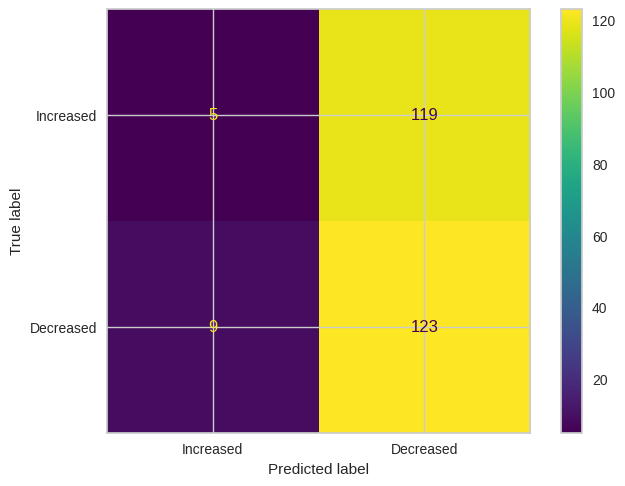

In [ ]:
ConfusionMatrixDisplay.from_estimator(mlp_bs, X_test_w, y_test_w_price_increased, display_labels=cls, ax=plt.subplot());

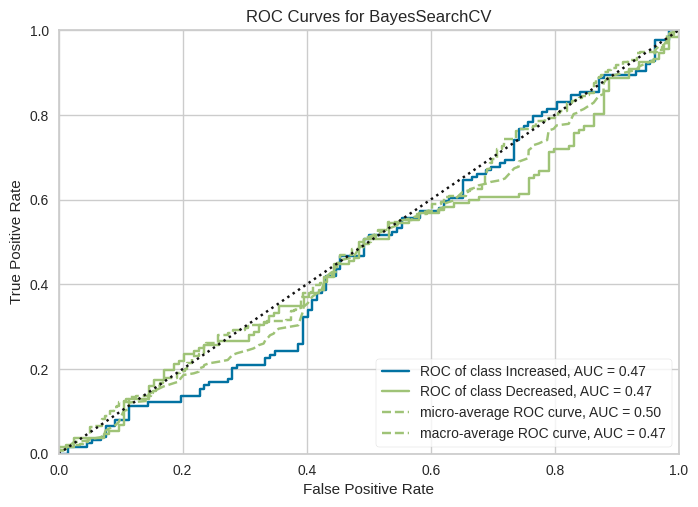

In [ ]:
roc_auc(mlp_bs, X_train_w, y_train_w_price_increased, X_test_w, y_test_w_price_increased, classes=cls);

In [ ]:
print(classification_report(mlp_bs.predict(X_test_w), y_test_w_price_increased, target_names=cls))

              precision    recall  f1-score   support

   Increased       0.04      0.36      0.07        14
   Decreased       0.93      0.51      0.66       242

    accuracy                           0.50       256
   macro avg       0.49      0.43      0.37       256
weighted avg       0.88      0.50      0.63       256



### Comparación entre Regresión lógistica y MLP
**Comenta las diferencias entre este modelo y la regresión logística. Te parecen adecuados los modelos que se han obtenido ¿Por qué?**

Tanto el modelo de Regresión Logística como el MLPClassifier utilizado para predecir la dirección del precio de las acciones de Google muestran un rendimiento relativamente bajo, con una tasa de acierto del 51.56% y 50% respectivamente, lo cual es apenas mejor que una elección al azar. Ambos modelos tienden a tener un sesgo hacia la predicción de disminución en el precio de las acciones, como se refleja en sus matrices de confusión. La Regresión Logística predijo exclusivamente disminuciones, 132 acertadas y 124 falsas. Y MLPClassifier con un sesgo similar, aunque menos pronunciado, acertó en 5 casos de aumento y en 123 de disminución, mientras que incurrió en 119 falsos negativos y 9 falsos positivos.

La principal diferencia entre estos modelos reside en su habilidad para predecir las distintas clases. Mientras que la Regresión Logística se inclina completamente hacia la predicción de disminuciones en el precio de las acciones, sin lograr identificar ningún aumento, el MLPClassifier muestra un balance más equilibrado en sus predicciones, acertando en algunas ocasiones tanto incrementos como disminuciones. Además, el MLPClassifier registra una validación cruzada ligeramente superior (54.67% frente a 51.76% de la Regresión Logística), reflejando una mejor, aunque aún limitada, capacidad para reconocer aumentos en el precio de las acciones. Esto se manifiesta en una matriz de confusión más variada y en las métricas de rendimiento, donde el MLPClassifier alcanza una precisión del 4% y un recall del 36% para la predicción de incrementos, en contraste con el 0% de precisión y recall en la misma categoría para la Regresión Logística.



In [ ]:
Counter(y_train_w_price_increased)

Counter({False: 447, True: 550})

La inclinación de ambos modelos a predecir predominantemente la disminución del valor de las acciones no parece originarse en un desbalance de clases. De hecho, los datos indican una distribución relativamente equilibrada, con una ligera tendencia hacia el aumento de precios, reflejada en 550 casos de incremento frente a 447 de disminución.

El desempeño deficiente de los modelos puede atribuirse primordialmente a la naturaleza compleja y volátil del mercado de valores. Este mercado está sujeto a una amplia variedad de influencias, muchas de ellas difíciles de prever y cuantificar: factores económicos globales, cambios en la tecnología, políticas gubernamentales, tendencias de consumo, el desempeño de la propia empresa, etc. La limitación en la variedad de datos utilizados —focalizándose en solo cinco empresas y restringiéndose a tres características específicas (precio final, volumen y GAP) por acción— probablemente restrinja la capacidad de los modelos para captar la complejidad del mercado y predecir sobre él. Un conjunto de datos más extenso y diversificado podría potencialmente mejorar la precisión de las predicciones. Asimismo, el periodo de cinco años de datos podría no ser suficiente para abarcar la totalidad de patrones y tendencias del NASDAQ.


## Apartado D
Intentamos predecir si el volumen de negociación de las acciones de Google sube o no respecto al día anterior ajustando un modelo de regresión logística y un modelo de MLP explorando sus hiperparámetros utilizando la exploración bayesiana. Obtenemos:
 * acierto de validación cruzada
 * acierto en el test
 * matriz de confusión
 * curva ROC
 * informe de clasificación

### Regresión logística
*Voy a comentar los resultados en el apartado de Comparación*

In [ ]:
lr = LogisticRegression(max_iter=10000)
print("validación cruzada:", np.mean(cross_val_score(lr, X_train_w, y_train_w_volume_increased, cv=ncv)))

validación cruzada: 0.6268383838383838


In [ ]:
param = {'penalty':['l2'], 'C':10**np.linspace(-3,3,51, endpoint=True)}
lr_bs =  BayesSearchCV(lr,param,n_iter=niter,cv=ncv, n_jobs=-1, refit=True,random_state=0)
lr_bs.fit(X_train_w, y_train_w_volume_increased);
print("acierto de test:", accuracy_score(y_test_w_volume_increased, lr_bs.predict(X_test_w)))

acierto de test: 0.56640625


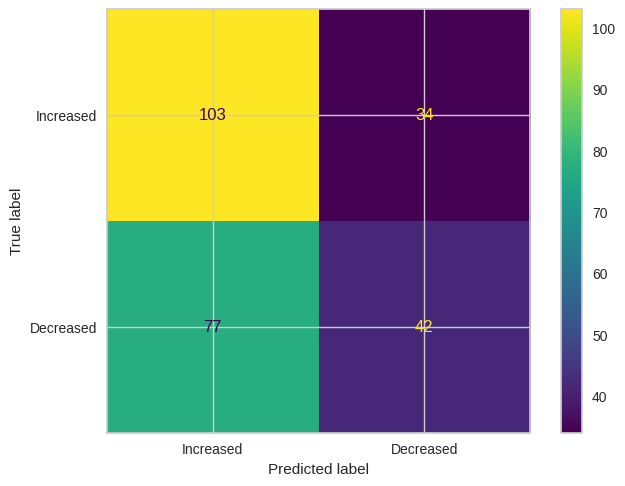

In [ ]:
ConfusionMatrixDisplay.from_estimator(lr_bs, X_test_w,y_test_w_volume_increased, display_labels=cls, ax=plt.subplot());

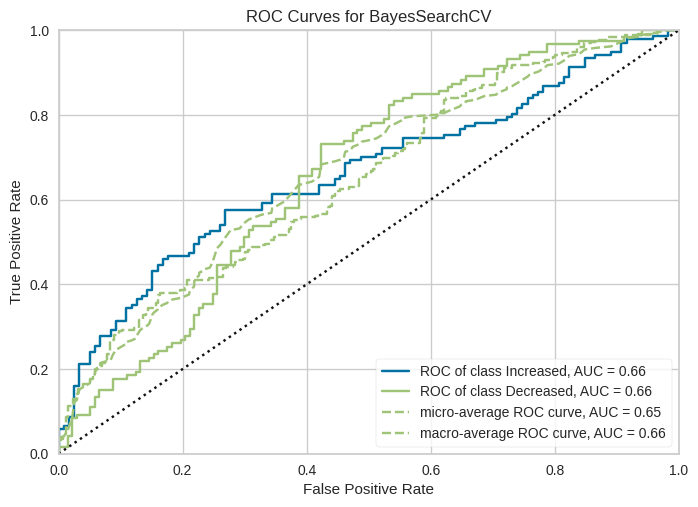

In [ ]:
roc_auc(lr_bs, X_train_w, y_train_w_volume_increased, X_test_w, y_test_w_volume_increased, classes=cls);

In [ ]:
print(classification_report(lr_bs.predict(X_test_w), y_test_w_volume_increased,target_names=cls))

              precision    recall  f1-score   support

   Increased       0.75      0.57      0.65       180
   Decreased       0.35      0.55      0.43        76

    accuracy                           0.57       256
   macro avg       0.55      0.56      0.54       256
weighted avg       0.63      0.57      0.58       256



### MLP
*Voy a comentar los resultados en el apartado de Comparación*

In [ ]:
mlp =  MLPClassifier(max_iter=10000,early_stopping=True,random_state=0)
print("validación cruzada:", np.mean(cross_val_score(mlp, X_train_w, y_train_w_volume_increased, cv=ncv)))

validación cruzada: 0.5585555555555556


In [ ]:
param = {'hidden_layer_sizes':[10, 50, 100, 200, 300],
'activation':['relu', 'identity', 'logistic'],
'alpha':[0.0001, 0.001, 0.01],
'momentum': [0.95, 0.90, 0.85, 0.8],
'learning_rate_init': [0.001, 0.01, 0.1],
'n_iter_no_change':[10, 20, 40, 50],
'learning_rate': ['constant', 'invscaling', 'adaptive']}
mlp_bs = BayesSearchCV(mlp,param,
                        n_iter=niter,
                        cv=ncv, n_jobs=-1,
                        refit=True,random_state=0)
mlp_bs.fit(X_train_w, y_train_w_volume_increased);
print("acierto de test:", accuracy_score(y_test_w_volume_increased, mlp_bs.predict(X_test_w)))

acierto de test: 0.6015625


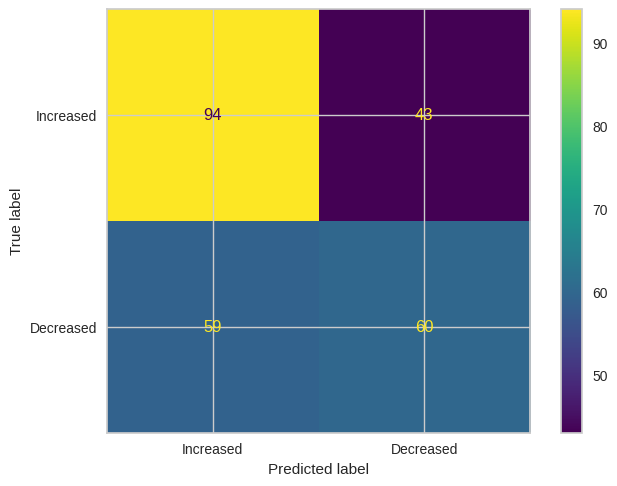

In [ ]:
ConfusionMatrixDisplay.from_estimator(mlp_bs, X_test_w, y_test_w_volume_increased, display_labels=cls, ax=plt.subplot());

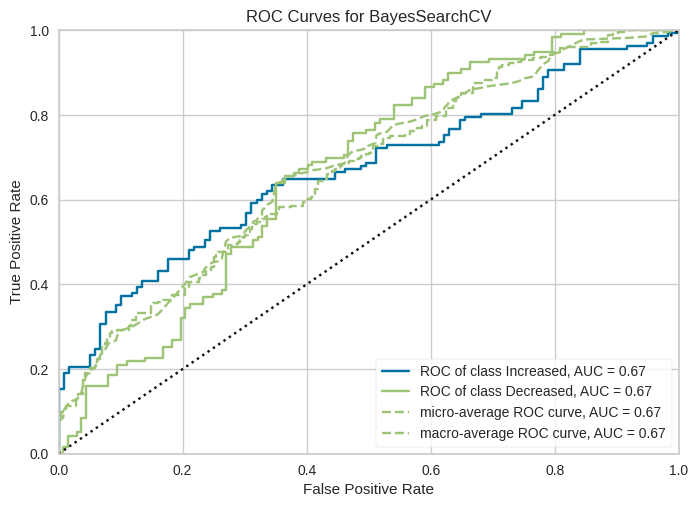

In [ ]:
roc_auc(mlp_bs, X_train_w, y_train_w_volume_increased, X_test_w, y_test_w_volume_increased, classes=cls);

In [ ]:
print(classification_report(mlp_bs.predict(X_test_w), y_test_w_volume_increased, target_names=cls))

              precision    recall  f1-score   support

   Increased       0.69      0.61      0.65       153
   Decreased       0.50      0.58      0.54       103

    accuracy                           0.60       256
   macro avg       0.60      0.60      0.59       256
weighted avg       0.61      0.60      0.60       256



### Comparación entre Regresión lógistica y MLP
**Compara los resultados de los modelos para este nuevo problema. ¿Hay alguna diferencia con la otra variable? ¿Se te ocurre alguna explicación?**

Los modelos de Regresión Logística y MLPClassifier, aplicados a la predicción del volumen de negociación de las acciones de Google, muestran un rendimiento superior en comparación con la predicción del precio de las acciones. La Regresión Logística logra una validación cruzada del 62.68% y una tasa de acierto del 56.64%, destacándose en predecir aumentos en el volumen de negociación con una precisión del 75%, pero mostrando menos efectividad en predecir disminuciones con solo un 35% de precisión. Por su parte, el MLPClassifier alcanza una validación cruzada del 55.86% y una tasa de acierto del 60.16%, presentando un equilibrio más consistente entre la precisión de predicciones de aumentos (69%) y disminuciones (50%).

Las diferencias clave entre ambos modelos se manifiestan en su capacidad para equilibrar las predicciones. Mientras que la Regresión Logística tiende a predecir más efectivamente los aumentos en el volumen de negociación, el MLPClassifier demuestra un balance más uniforme entre aumentos y disminuciones.

La mejora en la predicción del volumen de negociación en comparación con la predicción del precio de las acciones indica que estos modelos son posiblemente más adecuados para captar tendencias y patrones relacionados con el volumen de negociación, que podrían ser menos complejos o más regulares que los movimientos de precios. Sin embargo, la precisión de ambos modelos sigue siendo bastante mala, cercana al 50-60%, por los mismos motivos comentados en el apartado anterior: la naturaleza impredecible y compleja de la bolsa. Con un conjunto de datos más amplio y diversificado se podría mejorar la precisión de las predicciones.